# Analisis descriptivo

El conjunto de datos para este proyecto es un conjunto relacional de archivos que describen las órdenes de los clientes a lo largo del tiempo. En este primer notebook analizaré los datos dados y la posibles relaciones que hacer entre ellos para así poder realizar tanto una clusterización eficaz como un modelo predictivo eficiente.

**Objetivo:**

El objetivo de la competencia es predecir qué productos estarán en el próximo orden de un usuario. El conjunto de datos es anónimo y contiene una muestra de más de 3 millones de pedidos de más de 200,000 usuarios de Instacart.

Para cada usuario, se dan entre 4 y 100 de sus pedidos, con la secuencia de productos comprados en cada pedido.

### CARGA DE LIBREIAS Y DATOS

Las librerías utilizadas para este análisis son las siguientes (explicadas en word adjunto del TFM):
* numpy 
* pandas 
* matplotlib
* seaborn 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Generamos los dataFrames cargando los distintos CSV
order_products_train = pd.read_csv("../../DATOS/order_products__train.csv")
order_products_prior = pd.read_csv("../../DATOS/order_products__prior.csv")
orders = pd.read_csv("../../DATOS/orders.csv")
products = pd.read_csv("../../DATOS/products.csv")
aisles = pd.read_csv("../../DATOS/aisles.csv")
departments = pd.read_csv("../../DATOS/departments.csv")

##### Tablas de productos, pasillos y departamentos
Antes de profundizar en el análisis exploratorio, se debe saber un poco más sobre los archivos proporcionados. Para entenderlo mejor, primero se leen todos los archivos como dataframes de datos y luego veré las primeras filas.

In [4]:
print('Productos: {}'.format(products.shape[0]))
products.head()

Productos: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
print('Pasillos: {}'.format(aisles.shape[0]))
aisles.head()

Pasillos: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
print('departamentos: {}'.format(departments.shape[0]))
departments.head()

departamentos: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


#### Tablas de las ordenes

In [7]:
#Todas las ordenes
print('ordenes: {}'.format(orders.shape[0]))
orders.head()

ordenes: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
#Ordenes pasadas (Desglosadas por producto)
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
#Ordenes de entrenamiento
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Ahora voy a unir las tablas **products** + **aisles** + **departments** + **orders** para poder estudiar los productos más adelante

In [10]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior = pd.merge(order_products_prior, orders, on='order_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


## Validaciones
Como se puede ver, **orders.csv** tiene toda la información sobre el ID de pedido dado, como el **usuario** que compró el pedido, **cuándo** se compró, los **días desde el pedido anterior** y así sucesivamente.

Las columnas presentes en **order_products_train** y **order_products_prior son las mismas**. Entonces, ¿cuál es la diferencia entre estos archivos? Basicamente que uno de los ficheros contiene las ordenes que valen para entrenar el modelo y el otro (prior) contiene ordenes pasadas, es decir, conocidas.

En este conjunto de datos, se dan entre 4 y 100 pedidos de un cliente (comprobaré esto más adelante) y se debe **predecir los productos que se volverán a ordenar**. Así que la última orden del usuario ha sido eliminada y dividida en **conjuntos de prueba y entrenamiento**. Toda la información de pedidos anteriores del cliente están presentes en el archivo order_products_prior. También podemos observar que hay una columna en el archivo orders.csv llamada **eval_set** que nos indica a cuál de los tres conjuntos de datos (anterior, entrenar o probar) va la fila dada.

El fichero Order_products tiene información más detallada sobre los productos que se compraron en el pedido dado junto con el estado re-ordenado.

Primero obtengo el **número de filas en cada uno de los tres conjuntos**.

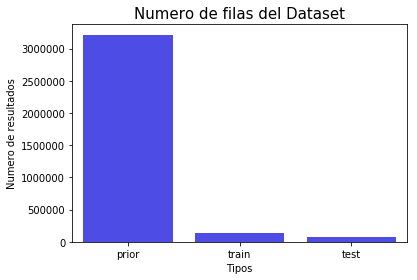

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

In [11]:
Num_orders = orders.eval_set.value_counts()
color = sns.color_palette()

sns.barplot(Num_orders.index, Num_orders.values, alpha=0.8, color='blue')
plt.ylabel('Numero de resultados')
plt.xlabel('Tipos')
plt.title('Numero de filas del Dataset', fontsize=15)
plt.show()
#Funcion para contar valores
def get_unique_count(x):
    return len(np.unique(x))

Num_orders = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
Num_orders

Así que **hay 206.209 clientes en total**. De los cuales, la última compra de **131.209** clientes se entrega como conjunto de entrenamiento y debemos predecir para el resto de **75.000** clientes.

Ahora validaré que se entregan realemete de 4 a 100 pedidos de un cliente en los datos.

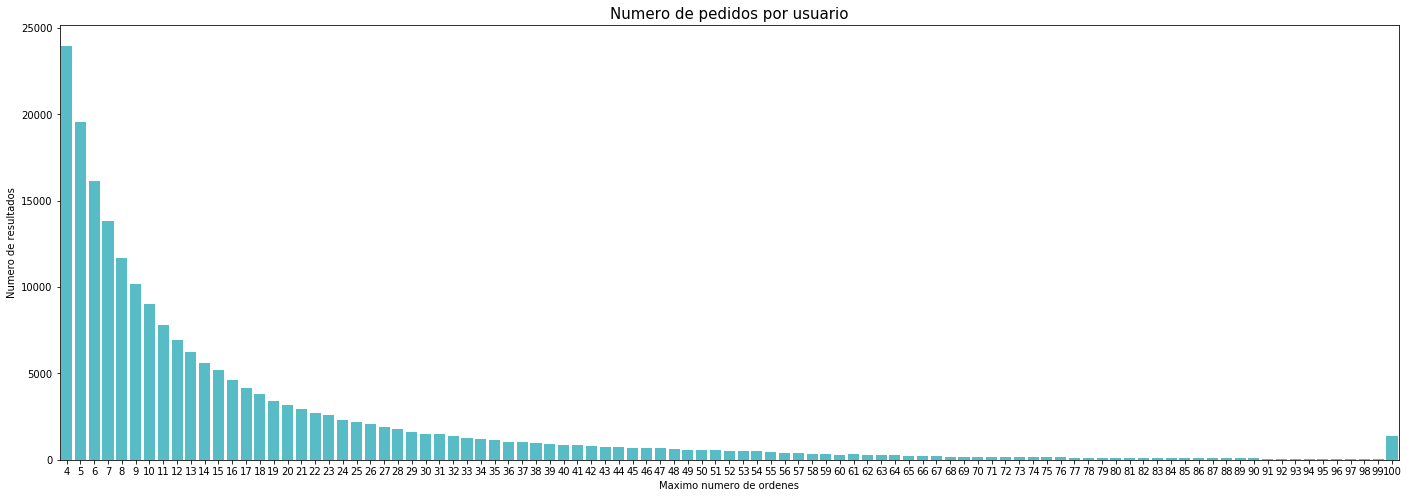

El numero maximo de ordenes es: 100
El numero minimo de ordenes es: 4


In [12]:
Num_orders = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
Num_orders = Num_orders.order_number.value_counts()

plt.figure(figsize=(24,8))
sns.barplot(Num_orders.index, Num_orders.values, alpha=0.8, color=color[9])
plt.title('Numero de pedidos por usuario', fontsize=15)
plt.ylabel('Numero de resultados')
plt.xlabel('Maximo numero de ordenes')
plt.show()

Num_orders = orders.groupby("user_id")["order_number"].aggregate(get_unique_count)
print'El numero maximo de ordenes es:', max(Num_orders)
print'El numero minimo de ordenes es:', min(Num_orders)

Por lo tanto, no hay pedidos inferiores a 4 y tiene un límite máximo de 100 como se indica en la página de datos

#### Estudio de la infuencia del día de la semana y la hora de la compra
* 0 Sabado  
* 1 Domingo  
* 2 Lunes  
* 3 Martes  
* 4 Miercoles  
* 5 Jueves  
* 6 Viernes

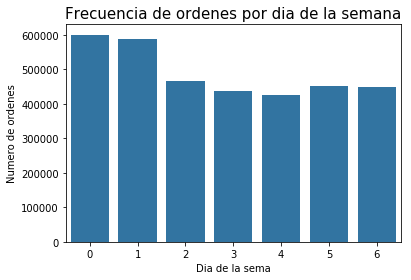

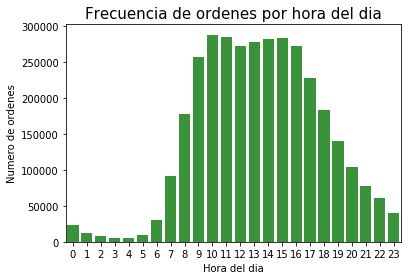

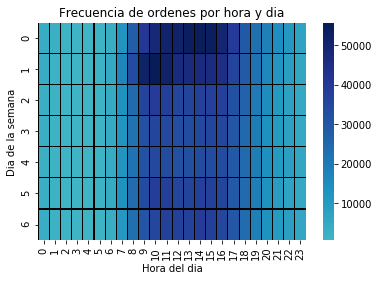

In [13]:
# Para día de la semana
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Numero de ordenes')
plt.xlabel('Dia de la sema')
plt.title("Frecuencia de ordenes por dia de la semana", fontsize=15)
plt.show()
# Para hora del dia
sns.countplot(x="order_hour_of_day", data=orders, color=color[2])
plt.ylabel('Numero de ordenes')
plt.xlabel('Hora del dia')
plt.title("Frecuencia de ordenes por hora del dia", fontsize=15)
plt.show()
# Día de la semana + hora del Día
agrupado = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
agrupado = agrupado.pivot('order_dow', 'order_hour_of_day', 'order_number')

sns.heatmap(agrupado,linewidths=0.05,linecolor="black",center=0,annot=False,cmap="YlGnBu")
plt.title("Frecuencia de ordenes por hora y dia")
plt.ylabel('Dia de la semana')
plt.xlabel('Hora del dia')
plt.show()

**Distribución con respecto al día de la semana**.

Parece que 0 y 1 es sábado y domingo cuando las órdenes son altas y bajas durante el miércoles.

**Distribución con respecto a la hora del día**.

Así que la mayoría de los pedidos se realizan durante el día. Ahora vamos a combinar el día de la semana y la hora del día para ver la distribución.

#### Tablero con la visión combinada de día de la semana + hora del día 
En este tablero se ve de forma rapida y sencilla lo que he podido comprobar en los dos graficos anteriores

Ahora voy a comprobar la **frecuencia de compra de los clientes**

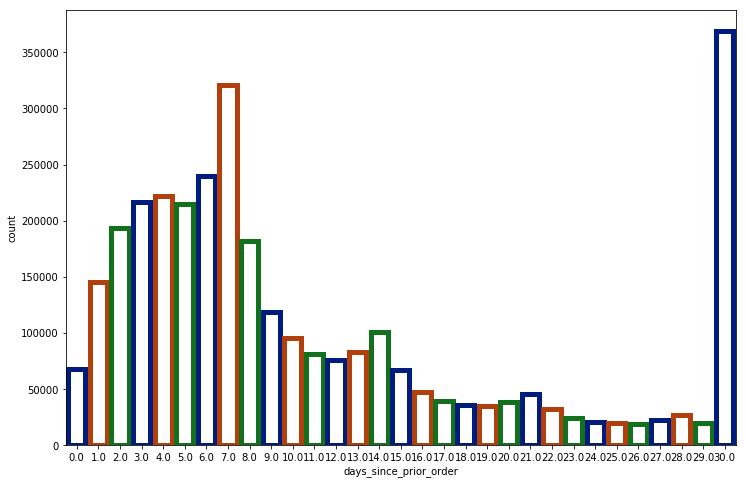

In [14]:
plt.figure(figsize=(12,8))
ax2=sns.countplot(x="days_since_prior_order",data=orders,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
plt.show()


Parece que los clientes ordenan **una vez en cada semana** (Se ve claramente el pico en los 7 días) o **una vez al mes** (pico a los 30 días). También se pueden ver picos más pequeños a los 14, 21 y 28 días (intervalos semanales).

Dado que mi objetivo es calcular los pedidos, verificaré el porcentaje de pedidos en el conjunto Prior y el conjunto de entrenamiento.

0.5896974667922161


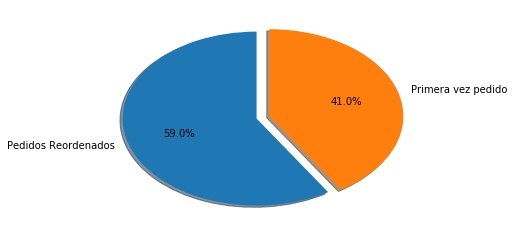

In [15]:
muestras=order_products_prior.shape[0]
muestras_reordenadas=(order_products_prior.reordered.sum())
#Porcentaje de ordenes con productos reordenados#
Porcentaje_reordenados=(muestras_reordenadas/float(muestras))
print Porcentaje_reordenados
# percentage of re-orders in train set #
order_products_train.reordered.sum() / float(order_products_train.shape[0])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pedidos Reordenados', 'Primera vez pedido'
sizes = [Porcentaje_reordenados, 1-Porcentaje_reordenados]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90) # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


En promedio, alrededor del 59% de los productos en un pedido son productos reordenados.

**Productos no re-ordenados:**

Ahora que hemos visto que se reordena el 59% de los productos, también habrá situaciones en las que **ninguno de los productos se reordene.** Voy a comprobarlo ahora.

In [16]:
print 'muestras conocidas reordenadas:'
grouped = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped["reordered"].loc[grouped["reordered"]>1] = 1
porcentaje_reordenados=grouped.reordered.value_counts() / grouped.shape[0]
print porcentaje_reordenados

print 'muestras de entrenamiento reordenadas:'
grouped = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped["reordered"].loc[grouped["reordered"]>1] = 1
porcentaje_reordenados_train=grouped.reordered.value_counts() / grouped.shape[0]
print porcentaje_reordenados_train

muestras conocidas reordenadas:
1    0.879151
0    0.120849
Name: reordered, dtype: float64
muestras de entrenamiento reordenadas:
1    0.93444
0    0.06556
Name: reordered, dtype: float64


Alrededor del 12% de los pedidos del conjunto anterior no tiene artículos reordenados, mientras que en el conjunto de entretenimiento es del 6,5%.

Ahora veamos el número de productos comprados en cada orden.

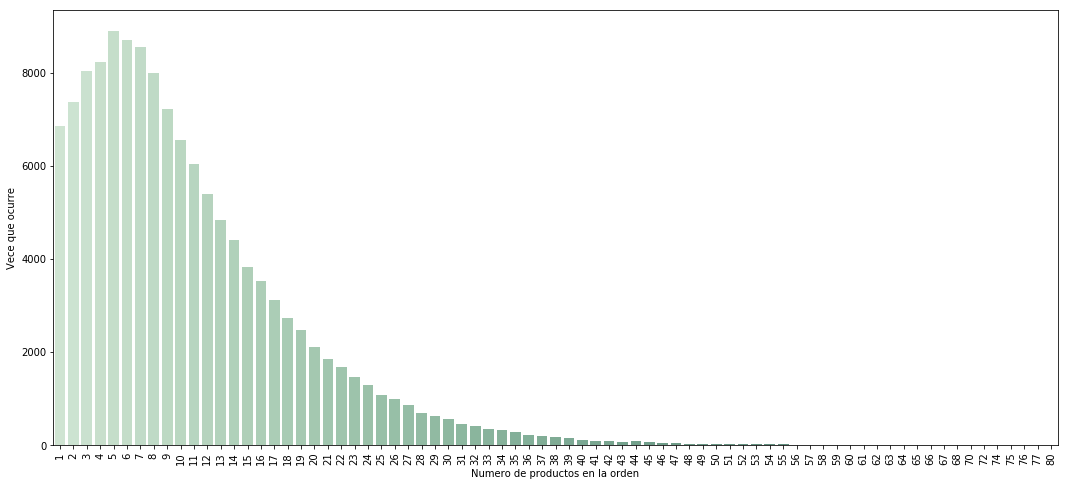

In [17]:
agrupados = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = agrupados.add_to_cart_order.value_counts()

plt.figure(figsize=(18,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.9,palette="ch:2.5,-.2,dark=.3")
plt.ylabel('Vece que ocurre')
plt.xlabel('Numero de productos en la orden')
plt.xticks(rotation='vertical')
plt.show()

Como se puede apreciar en el gráfico anterior, en la mayoría de pedidos se ordenan entre 3 y 8 productos

## Estudio de los productos

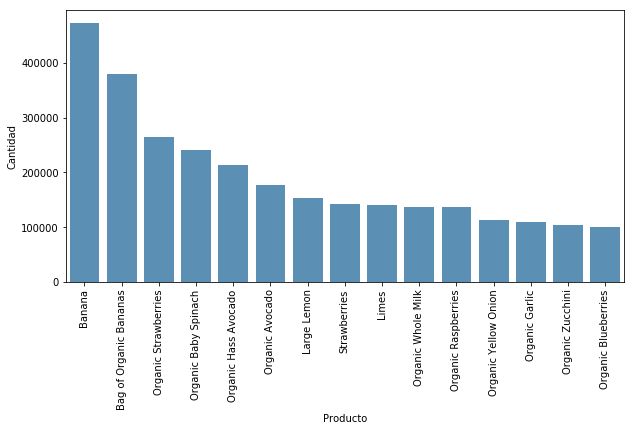

In [18]:
cuenta_productos = order_products_prior['product_name'].value_counts().reset_index().head(15)
cuenta_productos.columns = ['product_name', 'frequency_count']

plt.figure(figsize=(10,5))
sns.barplot(cuenta_productos.product_name, cuenta_productos.frequency_count, alpha=0.8, color=color[0])
plt.ylabel('Cantidad')
plt.xlabel('Producto')
plt.xticks(rotation='vertical')
plt.show()

La mayoría de ellos son productos orgánicos. También la mayoría de ellos son frutas.

Ahora voy a comprobar los **pasillos mas importantes**.

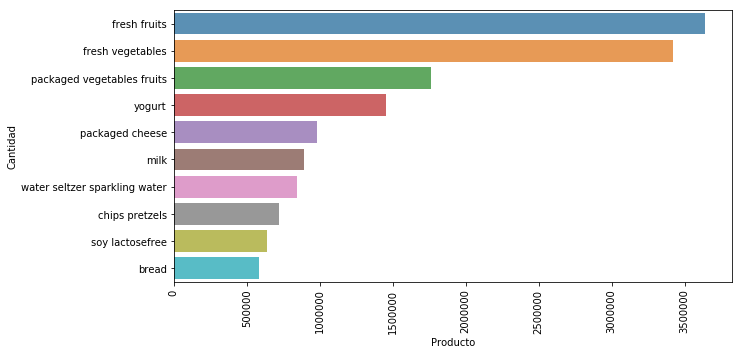

In [42]:
producto_pasillo = order_products_prior['aisle'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(producto_pasillo, producto_pasillo.index, alpha=0.8)
plt.ylabel('Cantidad')
plt.xlabel('Producto')
plt.xticks(rotation='vertical')
plt.show()

Los dos pasillos con más pedidos son frutas frescas y verduras frescas.

**Ahora voy a comprobar que departamentos tienen más pedidos y en cuales se reordenan más productos**


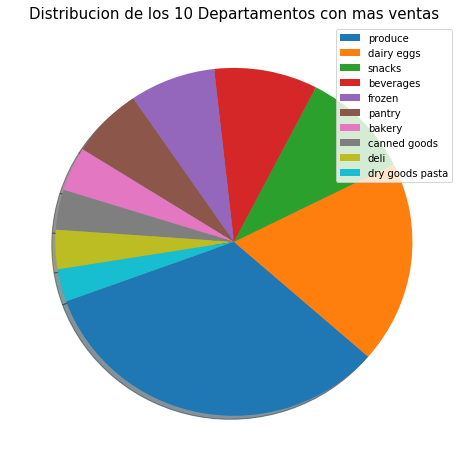

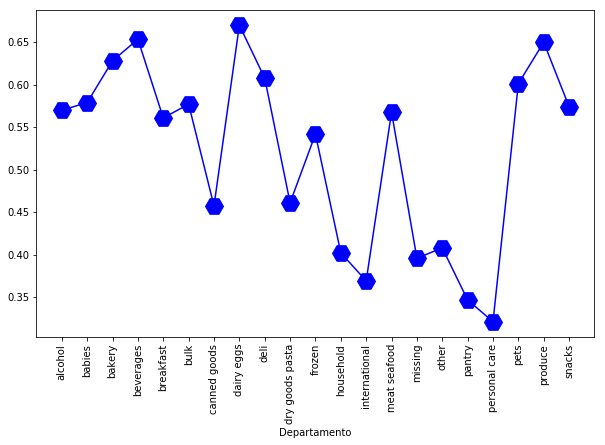

In [45]:
#Productos vendidos agrupados por departamento
plt.figure(figsize=(8,8))
temp_series = order_products_prior['department'].value_counts().head(10)
labels = (np.array(temp_series.index))
sizes = np.array(temp_series)
patches, texts = plt.pie(sizes,shadow=True,startangle=200)
plt.legend(patches, labels)
plt.title("Distribucion de los 10 Departamentos con mas ventas", fontsize=15)
plt.show()

#Productos Reodenados agrupados por departamento
grouped = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(10,6))
plt.xlabel('Departamento')
plt.xticks(rotation='vertical')
plt.plot(grouped['department'].values, grouped['reordered'].values, "H-",color='blue',markersize=18)
plt.show()

Produce, daity eggs y snacks son los **departamentos con más pedidos**. 

En cuanto al porcentaje de reordenes: **Personal care** tiene la relación de reorden más baja y **dairy eggs** tienen la relación de reorden más alta.

#### Ahora voy a comprobar si el orden en el que se añaden los productos a la cesta afecta a las probabilidades de reodenar dichos productos


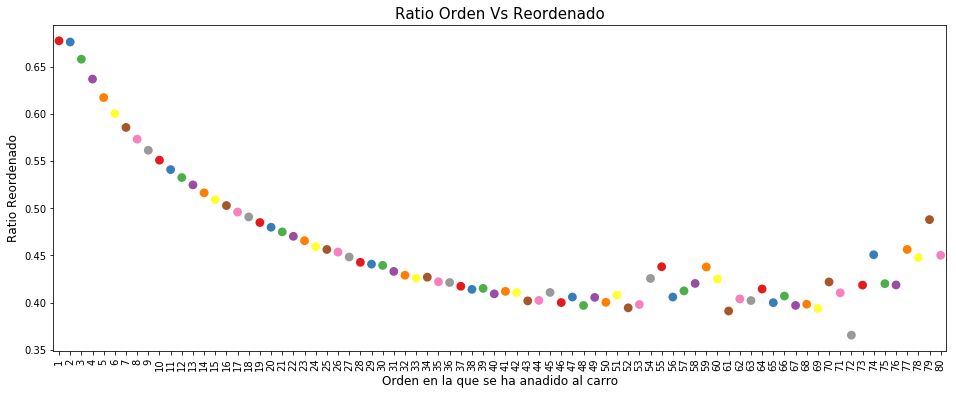

In [49]:
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>80] = 80
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(16,6))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, palette="Set1",join=False)
plt.ylabel('Ratio Reordenado', fontsize=12)
plt.xlabel('Orden en la que se ha anadido al carro', fontsize=12)
plt.title("Ratio Orden Vs Reordenado", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Parece que los productos que se **agregan al carrito en primer lugar** tienen **más probabilidades de ser reordenados** nuevamente en comparación con los que se agregaron posteriormente. Lo cual tiene sentido ya que son productos que estamos habituados a comprar y ya sabemos donde encontrarlos y que los necesitamos, y depues busquemos nuevos productos.

Relación de orden por variables basadas en tiempo

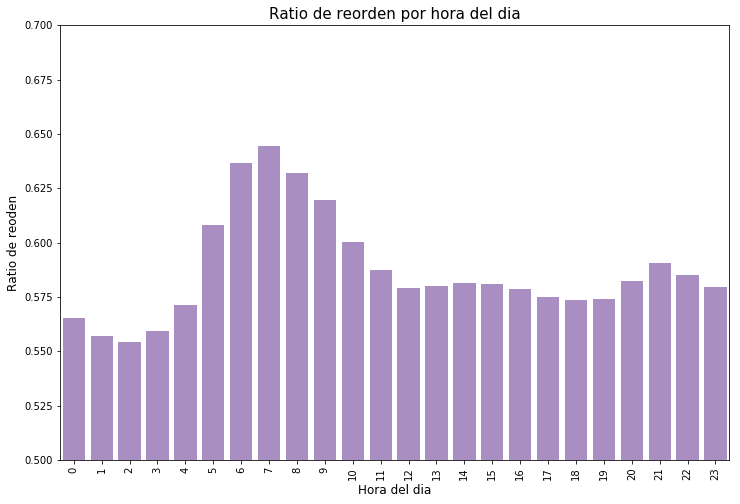

In [53]:
grouped = order_products_prior.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped['order_hour_of_day'].values, grouped['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Ratio de reoden', fontsize=12)
plt.xlabel('Hora del dia', fontsize=12)
plt.title("Ratio de reorden por hora del dia", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

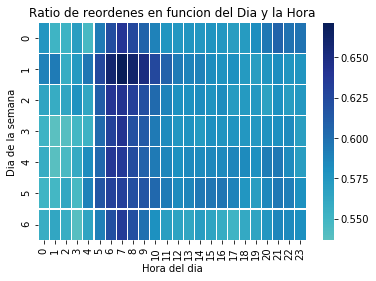

In [25]:
grouped = order_products_prior.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped = grouped.pivot('order_dow', 'order_hour_of_day', 'reordered')


sns.heatmap(grouped,linewidths=0.05,linecolor="white",center=0.55,annot=False,cmap="YlGnBu")
plt.title("Ratio de reordenes en funcion del Dia y la Hora")
plt.ylabel('Dia de la semana')
plt.xlabel('Hora del dia')
plt.show()



Como se puede ver **no hay grandes variaciones en cuanto a la hora** a la que se compra para el ratio de reorden de los productos, pero en torno a las **7 de la mañana** hay más probabilidades de reordenar productos. En cuanto al día hay menos variación pero el **Domingo** es el día que mas productos se reordenan.